In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  print("Downloaded helper_functions")

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists


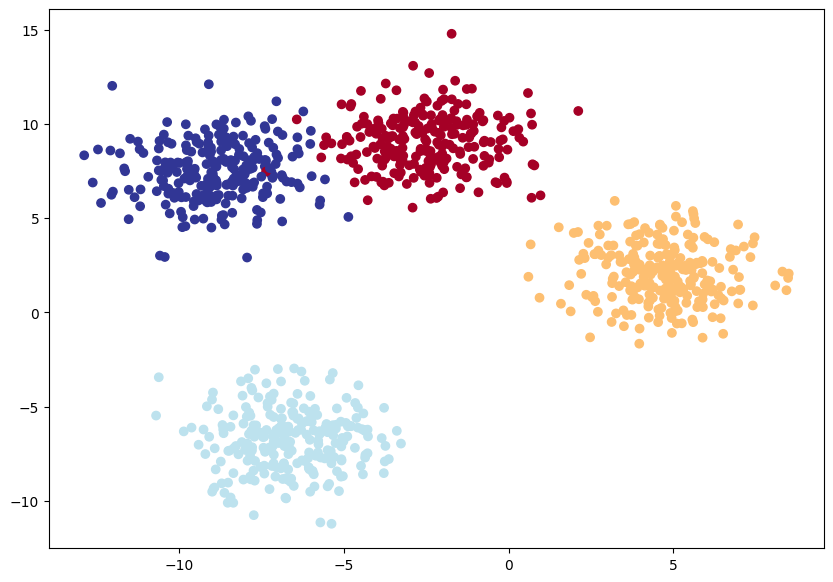

In [3]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# creating multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# converting to tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# train and test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED
)

# visualize the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [5]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features
      output_features (int): Number of output features
      hidden_units (int): Number of hidden units between layers
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [6]:
# loss fn and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

In [7]:
model_4.eval()
with torch.inference_mode():
  base_logits = model_4(X_blob_test.to(device))

base_logits[:5]

tensor([[-0.1796, -0.7237, -0.3263,  0.1920],
        [ 1.2246, -2.7198, -1.5345,  1.3212],
        [ 0.4952,  1.5465,  0.2750, -0.3584],
        [-0.2013,  0.0907, -0.0209, -0.0906],
        [ 0.5318, -2.8037, -1.3296,  1.1258]])

In [8]:
base_pred_probs = torch.softmax(base_logits, dim=1)
base_pred_probs.shape

torch.Size([200, 4])

In [9]:
y_preds = torch.argmax(base_pred_probs, dim=1)
y_preds[:5]

tensor([3, 3, 1, 1, 3])

In [10]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 100

for epoch in range(epochs):
  model_4.train()
  train_logits = model_4.forward(X_blob_train)
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
  train_loss = loss_fn(train_logits, y_blob_train)
  train_acc = accuracy_score(y_blob_train, train_preds)
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4.forward(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_score(y_blob_test, test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}\nTrain Loss: {train_loss:.4f}\tTrain Accuracy: {train_acc:.2f}%\nTest Loss: {test_loss:.4f} \tTest Accuracy: {test_acc:.2f}%\n")


Epoch: 0
Train Loss: 1.2287	Train Accuracy: 0.33%
Test Loss: 0.7801 	Test Accuracy: 0.85%

Epoch: 10
Train Loss: 0.1998	Train Accuracy: 0.96%
Test Loss: 0.1778 	Test Accuracy: 0.98%

Epoch: 20
Train Loss: 0.0923	Train Accuracy: 0.99%
Test Loss: 0.0841 	Test Accuracy: 0.99%

Epoch: 30
Train Loss: 0.0648	Train Accuracy: 0.99%
Test Loss: 0.0573 	Test Accuracy: 0.99%

Epoch: 40
Train Loss: 0.0519	Train Accuracy: 0.99%
Test Loss: 0.0443 	Test Accuracy: 0.99%

Epoch: 50
Train Loss: 0.0447	Train Accuracy: 0.99%
Test Loss: 0.0369 	Test Accuracy: 0.99%

Epoch: 60
Train Loss: 0.0401	Train Accuracy: 0.99%
Test Loss: 0.0321 	Test Accuracy: 0.99%

Epoch: 70
Train Loss: 0.0370	Train Accuracy: 0.99%
Test Loss: 0.0287 	Test Accuracy: 0.99%

Epoch: 80
Train Loss: 0.0347	Train Accuracy: 0.99%
Test Loss: 0.0263 	Test Accuracy: 0.99%

Epoch: 90
Train Loss: 0.0330	Train Accuracy: 0.99%
Test Loss: 0.0244 	Test Accuracy: 0.99%



In [11]:
model_4.eval()

with torch.inference_mode():
  pred_logits = model_4.forward(X_blob_test)

preds = torch.argmax(torch.softmax(pred_logits, dim=1), dim=1)
preds[:5] == y_blob_test[:5]

tensor([True, True, True, True, True])

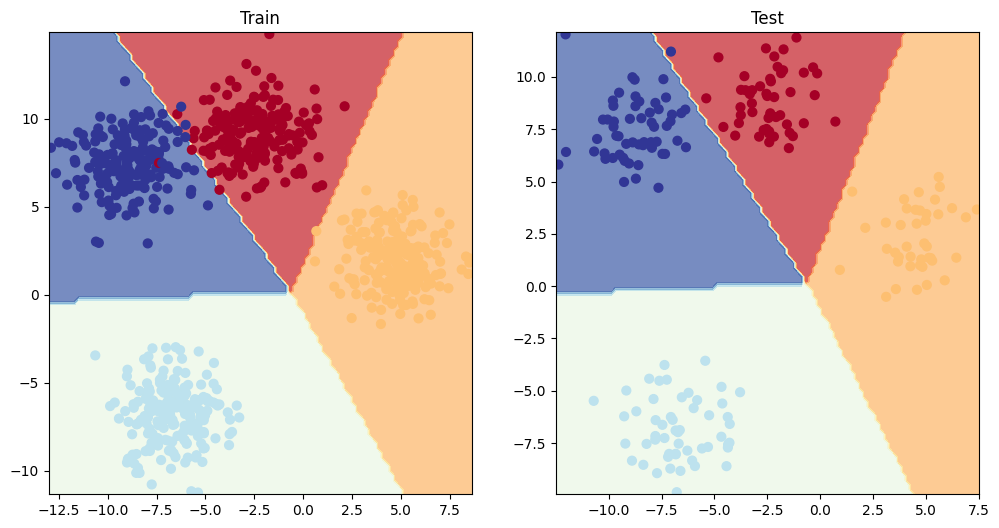

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)